<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This file is adapted from a notebook created by <a href="http://krasserm.github.io/">Martin Krasser</a> and made available <a href="https://github.com/krasserm/bayesian-machine-learning/blob/dev/bayesian-linear-regression/bayesian_linear_regression.ipynb">here</a> under <a href="https://github.com/krasserm/bayesian-machine-learning/blob/dev/LICENSE">Apache License</a>.</div> 

# Bayesian regression with linear basis function models

This article is an introduction to Bayesian regression with linear basis function models. After a short overview of the relevant mathematical results and their intuition, Bayesian linear regression is implemented from scratch with [NumPy](http://www.numpy.org/) followed by an example how [scikit-learn](https://scikit-learn.org/stable/) can be used to obtain equivalent results. It is assumed that you already have a basic understanding probability distributions and [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem). For a detailed mathematical coverage I recommend reading chapter 3 of [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) (PRML) but this is not necessary for following this article.  

You can also watch the serie of videos ML 10.1-7 at: https://www.youtube.com/playlist?list=PLD0F06AA0D2E8FFBA

## Linear basis function models

Linear regression models share the property of being linear in their parameters but not necessarily in their input variables. Using non-linear basis functions of input variables, linear models are able model arbitrary non-linearities from input variables to targets. Polynomial regression is such an example and will be demonstrated later. A linear regression model $y(\mathbf{x}, \mathbf{w})$ can therefore be defined more generally as

$$
y(\mathbf{x}, \mathbf{w}) = w_0 + \sum_{j=1}^{M-1}{w_j \phi_j(\mathbf{x})} = \sum_{j=0}^{M-1}{w_j \phi_j(\mathbf{x})} = \mathbf{w}^T \boldsymbol\phi(\mathbf{x}) \tag{1}
$$

where $\phi_j$ are basis functions and $M$ is the total number of parameters $w_j$ including the bias term $w_0$. Here, we use the convention $\phi_0(\mathbf{x}) = 1$. The simplest form of linear regression models are also linear functions of their input variables i.e. the set of basis functions in this case is the identity $\boldsymbol\phi(\mathbf{x}) = \mathbf{x}$. Other examples of basis functions will be given below. The target variable $t$ of an observation $\mathbf{x}$ is given by a deterministic function $y(\mathbf{x}, \mathbf{w})$ plus additive random noise $\epsilon$. 

$$
t = y(\mathbf{x}, \mathbf{w}) + \epsilon \tag{2}
$$

We make the assumption that the noise is normally distributed i.e. follows a Gaussian distribution with zero mean and precision (= inverse variance) $\beta$. The corresponding probabilistic model i.e. the conditional distribution of $t$ given $\mathbf{x}$ can therefore be written as

$$
p(t \lvert \mathbf{x}; \mathbf{w}, \beta) = 
\mathcal{N}(t \lvert y(\mathbf{x}, \mathbf{w}), \beta^{-1}) =
\sqrt{\beta \over {2 \pi}} \exp\left(-{\beta \over 2} (t - y(\mathbf{x}, \mathbf{w}))^2 \right) \tag{3}
$$

where the mean of this distribution is the regression function $y(\mathbf{x}, \mathbf{w})$. 

## Likelihood function

For fitting the model and for inference of model parameters we use a training set of $N$ independent and identically distributed (i.i.d.) observations $\mathbf{x}_1,\ldots,\mathbf{x}_N$ and their corresponding targets $t_1,\ldots,t_N$. After combining column vectors $\mathbf{x}_i$ into matrix $\mathbf{X}$, where $\mathbf{X}_{i,:} = \mathbf{x}_i^T$, and scalar targets $t_i$ into column vector $\mathbf{t}$ the joint conditional probability of targets $\mathbf{t}$ given $\mathbf{X}$ can be formulated as

$$
p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta) = 
\prod_{i=1}^{N}{\mathcal{N}(t_i ; \mathbf{w}^T \boldsymbol\phi(\mathbf{x}_i), \beta^{-1})} \tag{4}
$$

This is a function of parameters $\mathbf{w}$ and $\beta$ and is called the *likelihood function*. For better readability, it will be written as $p(\mathbf{t} ; \mathbf{w}, \beta)$ instead of $p(\mathbf{t} \lvert \mathbf{X} ; \mathbf{w}, \beta)$ from now on. The log of the likelihood function can be written as 

$$
\log p(\mathbf{t} ; \mathbf{w}, \beta) = 
{N \over 2} \log \beta - 
{N \over 2} \log {2 \pi} - 
\beta E_D(\mathbf{w}) \tag{5}
$$

where $E_D(\mathbf{w})$ is the sum-of-squares error function coming from the exponent of the likelihood function.

$$
E_D(\mathbf{w}) = 
{1 \over 2} \sum_{i=1}^{N}(t_i - \mathbf{w}^T \boldsymbol\phi(\mathbf{x}_i))^2 = 
{1 \over 2} \lVert \mathbf{t} - \boldsymbol\Phi \mathbf{w} \rVert^2 \tag{6}
$$

Matrix $\boldsymbol\Phi$ is called the *design matrix* and is defined as

$$
\boldsymbol\Phi = 
\begin{pmatrix}
\phi_0(\mathbf{x}_1) &  \phi_1(\mathbf{x}_1) & \cdots & \phi_{M-1}(\mathbf{x}_1) \\ 
\phi_0(\mathbf{x}_2) &  \phi_1(\mathbf{x}_2) & \cdots & \phi_{M-1}(\mathbf{x}_2) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_0(\mathbf{x}_N) &  \phi_1(\mathbf{x}_N) & \cdots & \phi_{M-1}(\mathbf{x}_N)
\end{pmatrix} \tag{7}
$$

## Maximum likelihood

Maximizing the log likelihood (= minimizing the sum-of-squares error function) w.r.t. $\mathbf{w}$ gives the maximum likelihood estimate of parameters $\mathbf{w}$: 

$$ \mathbf{w}_{ML} = \underset{\mathbf{w}}{\arg\max} \log p(\mathbf{t} ; \mathbf{w}, \beta) = \underset{\mathbf{w}}{\arg\min} E_D(\mathbf{w}) = (\boldsymbol\Phi^\top \boldsymbol\Phi)^{-1} \boldsymbol\Phi^\top \mathbf{t}, $$

which also corresponds to the [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) (OLS) solution.

Maximum likelihood estimation can lead to severe over-fitting if complex models (e.g. polynomial regression models of high order) are  fit to datasets of limited size. Moreover, in many situations (and  depending on the basis functions that are used), the matrix $\boldsymbol\Phi^\top \boldsymbol\Phi$ may be ill-conditioned and
difficult to invert. This means that if noise is included in
the signal observations, it will heavily affect the estimation
of the weights. 

A common approach to prevent these two issues is to add a regularization term to the error function. As we will see shortly, this regularization term arises naturally when following a Bayesian approach (more precisely, when defining a prior distribution over parameters $\mathbf{w}$). 

## Bayesian approach

### Prior distribution

For a Bayesian treatment of linear regression we need a prior probability distribution over model parameters $\mathbf{w}$. This
introduces bias in the estimation but also greatly reduces
its variance, which is a major problem of the ML estimate. For reasons of simplicity, we will use an isotropic Gaussian distribution over parameters $\mathbf{w}$ with zero mean:

$$
p(\mathbf{w} ; \alpha) = \mathcal{N}(\mathbf{w} ; \mathbf{0}, \alpha^{-1}\mathbf{I}) \tag{8}
$$

An isotropic Gaussian distribution has a diagonal covariance matrix where all diagonal elements have the same variance $\alpha^{-1}$ ($\alpha$ is the precision of the prior). Therefore, all the scalar weights have the same prior. A zero mean favors small(er) values of parameters $w_j$ a priori. 

Notice that here the weights $\mathbf{w}$ are hidden random variables and the deterministic model parameters are the prior precision $\alpha$  and the likelihood precision $\beta$.

### Marginal likelihood

We have $\mathbf{t} = \boldsymbol\Phi \mathbf{w} + \boldsymbol \epsilon$.

As the affine transformation of a Gaussian random vector, we have:

$$ p(\boldsymbol\Phi \mathbf{w}; \alpha) = \mathcal{N}(\boldsymbol\Phi \mathbf{w} ; \mathbf{0}, \alpha^{-1}\boldsymbol\Phi \boldsymbol\Phi^\top). $$

We also recall that $p(\boldsymbol \epsilon ; \beta) = \mathcal{N}(0, \beta^{-1}\mathbf{I}).$

By linear combination of two independent Gaussian random vectors, we have the following marginal likelihood:

$$ p(\mathbf{t} ; \alpha, \beta) = \mathcal{N}(\mathbf{t} ; \mathbf{0}, \alpha^{-1}\boldsymbol\Phi \boldsymbol\Phi^\top + \beta^{-1}\mathbf{I}) \tag{9}. $$

The marginal likelihood can be used to compare models of different complexity directly by evaluating their marginal likelihood on training data alone, without needing a validation set. Further below we'll see an example how polynomial models of different complexity (i.e. different polynomial degree) can be compared directly by evaluating their marginal likelihood function alone. The highest marginal likelihood is usually obtained for models of intermediate complexity i.e. for models whose complexity is just high enough for explaining the data sufficiently well. 

### Posterior distribution

The relationship between marginal likelihood (also called evidence), likelihood, prior, posterior is of course given by Bayes' theorem

$$
p(\mathbf{w} \lvert \mathbf{t}; \alpha, \beta) = 
{p(\mathbf{t} \lvert \mathbf{w}; \beta) p(\mathbf{w} ; \alpha) \over p(\mathbf{t} ; \alpha, \beta)} 
$$

The prior is [conjugate](https://en.wikipedia.org/wiki/Conjugate_prior) to the likelihood meaning that the posterior distribution has the same functional form as the prior i.e. is also a Gaussian:

$$
p(\mathbf{w} \lvert \mathbf{t}; \alpha, \beta) = \mathcal{N}(\mathbf{w} ; \mathbf{m}_N, \mathbf{S}_N). \tag{10}
$$

---

**Exercise 1** 


Show that the mean vector and inverse covariance matrix (= precision matrix) are given by: 

$$
\begin{align*}
\mathbf{m}_N &= \beta \mathbf{S}_N \boldsymbol\Phi^T \mathbf{t}  \tag{11} \\
\mathbf{S}_N^{-1} &= \alpha\mathbf{I} + \beta \boldsymbol\Phi^T \boldsymbol\Phi  \tag{12}
\end{align*}
$$

---


Since the posterior is proportional to the product of likelihood and prior, the log of the posterior distribution is proportional to the sum of the log likelihood and the log of the prior

$$
\log p(\mathbf{w} \lvert \mathbf{t}; \alpha, \beta) = 
-\beta E_D(\mathbf{w}) - \alpha E_W(\mathbf{w}) + \mathrm{const.} \tag{13}
$$

where $E_D(\mathbf{w})$ is defined by $(6)$ and 

$$
E_W(\mathbf{w}) = {1 \over 2} \mathbf{w}^T \mathbf{w} \tag{14}
$$

Maximizing the log posterior w.r.t. $\mathbf{w}$ gives the [maximum-a-posteriori](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) (MAP) estimate of $\mathbf{w}$. Maximizing the log posterior is equivalent to minimizing the sum-of-squares error function $E_D$ plus a quadratic regularization term $E_W$. This particular form regularization is known as *L2 regularization* or *weight decay* as it limits the magnitude of weights $w_j$. The contribution of the regularization term is determined by the ratio $\alpha / \beta$.

### Posterior predictive distribution

For making a prediction $t_{\star}$ at a new location $\mathbf{x}_\star$ we use the posterior predictive distribution which is defined as

$$
p(t_{\star} \lvert \mathbf{t}; \alpha, \beta) = \int p(t_\star, \mathbf{w} \lvert \mathbf{t} ; \alpha, \beta) d\mathbf{w} = 
\int{p(t_\star \lvert \mathbf{w}; \beta) p(\mathbf{w} \lvert \mathbf{t}; \alpha, \beta) d\mathbf{w}} \tag{15}
$$
where $\mathbf{t}$ is the vector of target values from the training set, and we have again omitted the corresponding input vectors from the right-hand side of the conditioning bars to simplify the notation.

The posterior predictive distribution includes uncertainty about parameters $\mathbf{w}$ into predictions by weighting the conditional distribution $p(t_\star \lvert \mathbf{w}; \beta)$ with the posterior probability of weights $p(\mathbf{w} \lvert \mathbf{t}; \alpha, \beta)$ over the entire weight parameter space. By using the predictive distribution we can not only compute the expected value of $t_\star$ at a new location $\mathbf{x}_\star$, but also the uncertainty for that prediction. 

Instead of computing the integral in (15), we can use the fact that $t_{\star}$ is a linear combination of two independent Gaussian random variables:

$$ t_{\star} = \mathbf{w}^\top \boldsymbol\phi(\mathbf{x}_\star) + \epsilon, $$

where we recall that $p(\mathbf{w} | \mathbf{t}; \alpha, \beta) = \mathcal{N}(\mathbf{w}; \mathbf{m}_N, \mathbf{S}_N)$ and $p(\epsilon; \beta) = \mathcal{N}(\epsilon; 0, \beta^{-1})$.

Therefore, the posterior predictive distribution is a Gaussian distribution

$$
p(t_{\star} \lvert \mathbf{t}; \alpha, \beta) = 
\mathcal{N}(t \lvert \mathbf{m}_N^\top \boldsymbol\phi(\mathbf{x}_{\star}), \sigma_N^2(\mathbf{x})) \tag{16}
$$

where $\mathbf{m}_N^\top \boldsymbol\phi(\mathbf{x}_{\star})$ is the predictive mean and $\sigma_N^2(\mathbf{x})$ is the corresponding predictive variance

$$
\sigma_N^2(\mathbf{x}) = {1 \over \beta} + \boldsymbol\phi(\mathbf{x})^\top \mathbf{S}_N \boldsymbol\phi(\mathbf{x}) \tag{17}
$$

The first term in $(17)$ represents the inherent noise in the data and the second term covers the uncertainty about parameters $\mathbf{w}$.

What do we actually do with the posterior predictive distribution? Often, we want to make a decision. We can formulate this as minimizing the expected loss under the posterior predictive distribution. This is
known as decision theory. For instance, we may want to choose a single prediction $\hat{t}$ that minimizes the expected squared error loss, which would result in the predictive mean: 

$$ \hat{t}_{MSE} = \underset{\hat{t}}{\arg\min}\,\, \mathbb{E}_{p(t_{\star} \lvert \mathbf{t}; \alpha, \beta)}[(\hat{t} - t_{\star})^2] = \mathbb{E}_{p(t_{\star} \lvert \mathbf{t}; \alpha, \beta)}[t_{\star}] = \mathbf{m}_N^\top \boldsymbol\phi(\mathbf{x}_{\star}). \tag{19} $$



### Posterior and posterior predictive distribution

We start with the implementation of the posterior and posterior predictive distributions. Function `posterior` computes the mean and covariance matrix of the posterior distribution and function `posterior_predictive` computes the mean and the variances of the posterior predictive distribution. Here, readability of code and similarity to the mathematical definitions has higher priority than optimizations.

In [6]:
import numpy as np
np.random.seed(0)

#后验分布
def posterior(Phi, t, alpha, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T @ Phi
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N @ Phi.T @ t

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N

#后验预测
def posterior_predictive(Phi_test, m_N, S_N, beta):
    """Computes mean and variances of the posterior predictive distribution."""
    t_mse = Phi_test @ m_N
    # Only compute variances (diagonal elements of covariance matrix)
    sigma_N2 = 1 / beta + np.sum(Phi_test @ S_N * Phi_test, axis=1)
    
    return t_mse, sigma_N2

### Example datasets

The datasets used in the following examples are based on $N$ scalar observations $x_{i = 1,\ldots,N}$ which are combined into a $N \times 1$ matrix $\mathbf{X}$ (in other words, a column vector). Target values $\mathbf{t}$ are generated from $\mathbf{X}$ with functions `f` and `g` which also generate random noise whose variance can be specified with the `noise_variance` parameter. We will use `f` for generating noisy samples from a straight line and `g` for generating noisy samples from a sinusoidal function.

In [7]:
f_w0 = -0.3
f_w1 =  0.5

# f for generating noisy samples from a straight line
def f(X, noise_variance):
    '''Linear function plus noise'''
    return f_w0 + f_w1 * X + noise(X.shape, noise_variance)

# g for generating noisy samples from a sinusoidal function.
def g(X, noise_variance):
    '''Sinusoidial function plus noise'''
    return 0.5 + np.sin(2 * np.pi * X) + noise(X.shape, noise_variance)


def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

### Basis functions

For straight line fitting, a model that is linear in its input variable $x$ is sufficient. Hence, we don't need to transform $x$ with a basis function which is equivalent to using an identity basis function.

For fitting a linear model to a sinusoidal dataset we transform input $x$ with Gaussian basis functions:

$$ \phi_j(x) = \exp\left( -\frac{(x-\mu_j)^2}{2 s^2} \right), \qquad j \in \{1, ..., M\}, $$

where $\mu_j$ governs the location of the $j$-th basis function in the input space, and $s$ governts its scale.

Later, we will also use polynomial basis functions:

$$ \phi_j(x) = x^j, \qquad j \in \{1, ..., M\}. $$

These non-linear basis functions are necessary to model the non-linear relationship between input $x$ and target $t$. The design matrix $\boldsymbol\Phi$ can be computed from observations $\mathbf{X}$ and a parametric basis function with function `expand`. This function also prepends a column vector $\mathbf{1}$ according to $\phi_0(x) = 1$.

In [8]:
def identity_basis_function(x):
    return x


def gaussian_basis_function(x, mu, sigma=0.1):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)


def polynomial_basis_function(x, power):
    return x ** power

#bf = basis functions
def expand(x, bf, bf_args=None):
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.concatenate([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args], axis=1)

Gaussian and polynomial basis functions are illustrated in the following cell.

Text(0.5, 0, 'x')

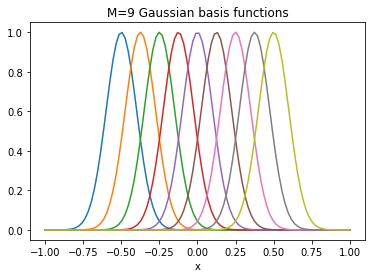

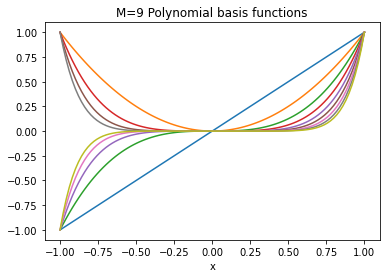

In [9]:
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 100).reshape(-1, 1)

plt.figure()
for phi in [gaussian_basis_function(x, bf_arg) for bf_arg in np.linspace(-0.5, 0.5, 9)]:
    plt.plot(x, phi)
plt.title('M=9 Gaussian basis functions')
plt.xlabel('x')

plt.figure()
for phi in [polynomial_basis_function(x, bf_arg) for bf_arg in np.arange(1,10,1)]:
    plt.plot(x, phi)
plt.title('M=9 Polynomial basis functions')
plt.xlabel('x')

### Straight line fitting

For straight line fitting, we use a linear regression model of the form 

$$y(x, \mathbf{w}) = w_0 + w_1 x$$ 

and do Bayesian inference for model parameters $\mathbf{w}$. Predictions are made with the posterior predictive distribution. Since this model has only two parameters, $w_0$ and $w_1$, we can visualize the posterior density in 2D which is done in the first column of the following output. Rows use an increasing number of training data from a training dataset.

In [10]:
from utils import (plot_data, plot_truth, plot_predictive, 
                   plot_posterior_samples, plot_posterior, 
                   print_comparison)

import matplotlib.pyplot as plt
%matplotlib inline

# Training dataset sizes
N_list = [1, 3, 20] 

beta = 25.0 # model parameters assumed to be known
alpha = 2.0

# Training observations in [-1, 1)
X = np.random.rand(N_list[-1], 1) * 2 - 1

# Training target values
t = f(X, noise_variance=1/beta)

# Test observations
X_test = np.linspace(-1, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = f(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, identity_basis_function)

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, identity_basis_function)
    
    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    
    plt.subplot(len(N_list), 3, i * 3 + 1)
    plot_posterior(m_N, S_N, f_w0, f_w1)
    plt.title(f'Posterior density (N = {N})')
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.5, 1.0)
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 3)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var))
    plt.ylim(-1.5, 1.0)
    plt.legend()

ImportError: cannot import name 'plot_data' from 'utils' (C:\Users\OUYANG Xinjian\Anaconda3\lib\site-packages\utils\__init__.py)

In the second column, 5 random weight samples are drawn from the posterior and the corresponding regression lines are plotted in red color. The line resulting from the true parameters, `f_w0` and `f_w1` is plotted as dashed black line and the noisy training data as black dots. The third column shows the mean and the standard deviation of the posterior predictive distribution along with the true model and the training data.

It can be clearly seen how the posterior density in the first column gets more sharply peaked as the size of the dataset increases which corresponds to a decrease in the sample variance in the second column and to a decrease in prediction uncertainty as shown in the third column. Also note how prediction uncertainty is higher in regions of less observations. 

### Gaussian basis functions

The following example demonstrates how to fit a Gaussian basis function model to a noisy sinusoidal dataset. It uses 9 Gaussian basis functions with mean values equally distributed over $[0, 1]$ each having a standard deviation of $0.1$. Inference for parameters $\mathbf{w}$ is done in the same way as in the previous example except that we now infer values for 10 parameters (bias term $w_0$ and $w_1,\ldots,w_9$ for the 9 basis functions) instead of 2. We therefore cannot display the posterior density unless we selected 2 parameters at random.

NameError: name 'plot_data' is not defined

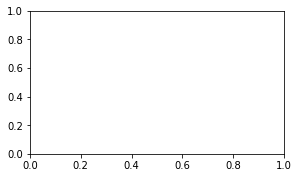

In [11]:
N_list = [3, 8, 20]

beta = 25.0
alpha = 2.0

# Training observations in [-1, 1)
X = np.random.rand(N_list[-1], 1)

# Training target values
t = g(X, noise_variance=1/beta)

# Test observations
X_test = np.linspace(0, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = g(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, bf=gaussian_basis_function, bf_args=np.linspace(0, 1, 9))

plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, bf=gaussian_basis_function, bf_args=np.linspace(0, 1, 9))

    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    
    plt.subplot(len(N_list), 2, i * 2 + 1)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.0, 2.0)
    plt.legend()
    
    plt.subplot(len(N_list), 2, i * 2 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var))
    plt.ylim(-1.0, 2.0)
    plt.legend()

Again, as the size of the dataset increases the posterior sample variance and the prediction uncertainty decreases. Also, regions with less observations have higher prediction uncertainty.

### Marginal likelihood evaluation

As already mentioned, the evidence function or marginal likelihood can be used to compare models of different complexity using training data alone. This is shown here for 10 polynomial basis function models of different degree using a sinusoidal dataset generated with `g`. For evaluating the log marginal likelihood we implement the log of $(9)$ as `log_marginal_likelihood` function. 

In [ ]:
def log_marginal_likelihood(Phi, t, alpha, beta):
    """Computes the log of the marginal likelihood."""
    
    Sigma = 1/alpha * Phi @ Phi.T + 1/beta * np.eye(Phi.shape[0])
    
    _, logdet = np.linalg.slogdet(2*np.pi*Sigma)
    
    gauss_exp = np.squeeze(t.T @ np.linalg.inv(Sigma) @ t)
    
    return -0.5 * (logdet + gauss_exp)

The 10 polynomial basis function models of degrees 0-9 are compared based on the log marginal likelihood computed with a dataset of 10 observations. We still assume that the values of $\alpha$ and $\beta$ are known and will see in the next section how they can be inferred estimated. When plotting the posterior predictive distribution of the polynomial models we can see that a model of degree 3 has already sufficient complexity to explain the data reasonably well.

In [ ]:
N = 10

beta = 1 / (0.3 ** 2)
alpha = 0.005

degree = 9
degrees = range(degree + 1)

X = np.linspace(0, 1, N).reshape(-1, 1)
t = g(X, noise_variance=1/beta)

Phi = expand(X, bf=polynomial_basis_function, bf_args=degrees[1:])
Phi_test = expand(X_test, bf=polynomial_basis_function, bf_args=degrees[1:])

plt.figure(figsize=(18, 8))
plt.subplots_adjust(hspace=0.4)

for d in degrees:
    up = d + 1
    m_N, S_N = posterior(Phi[:,:up], t, alpha, beta)
    y, y_var = posterior_predictive(Phi_test[:,:up], m_N, S_N, beta)

    plt.subplot(2, 5, up)
    plot_data(X, t)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var), y_label=None, std_label=None, plot_xy_labels=False)
    plt.title(f'Degree = {d}')
    plt.ylim(-1.0, 2.0)

We also see how polynomial models of higher degree do not overfit to the dataset which is a consequence of using a prior over model parameters that favors small(er) parameter values. This is equivalent to minimizing a sum-of-squares error function plus a quadratic regularization term whose strength is given by ratio $\alpha / \beta$ as can be seen from equation $(13)$. 

When evaluating the log marginal likelihood for all 10 polynomial models we usually obtain the highest value for models of degree 3 or 4 (depending on the non-deterministic part i.e. noise of the generated dataset results may vary slightly). This is consistent with the observation that a polynomial model of degree 3 already explains the data sufficiently well and confirms that marginal likelihood evaluation favors models of intermediate complexity.

In [ ]:
mlls = []

for d in degrees:
    mll = log_marginal_likelihood(Phi[:,:d+1], t, alpha=alpha, beta=beta)
    mlls.append(mll)

degree_max = np.argmax(mlls)
    
plt.plot(degrees, mlls)
plt.axvline(x=degree_max, ls='--', c='k', lw=1)
plt.xticks(range(0, 10))
plt.xlabel('Polynomial degree')
plt.ylabel('Log marginal likelihood');

It is also interesting to see that a polynomial model of degree 1 (straight line) seems to explain the data better than a model of degree 2. This is because the data-generating sinusoidal function has no even terms in a polynomial expansion. A model of degree 2 therefore only adds complexity without being able to explain the data better. This higher complexity is penalized by the evidence function (see also section 3.4. in [PRML](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)).

### Parameters estimation

So far, we have assumed that the values of $\alpha$ and $\beta$ are known, which is generally not the case. Estimates for $\alpha$ and $\beta$ can be obtained by maximizing the marginal (log-)likelihood $p(\mathbf{t} ; \alpha, \beta)$  w.r.t. $\alpha$ and $\beta$. This approach is known as [empirical Bayes](https://en.wikipedia.org/wiki/Empirical_Bayes_method). It can be shown that this is a good approximation for a fully Bayesian treatment if the posterior for $\alpha$ and $\beta$ is sharply peaked around the most probable value and the prior is relatively flat which is often a reasonable assumption. Empirical Bayes allows us to estimate values for $\alpha$ and $\beta$, and hence the regularization strength $\alpha / \beta$, from training data alone i.e. without using a validation set. 

Unfortunately, direct maximization of the marginal likelihood presents computational difficulties. Instead, the expectation-maximization (EM) algorithm provides an efficient framework to simultaneously
obtain estimates for $\alpha$ and $\beta$ and infer the posterior of $w$, which depends on these parameters. Notice, that although the EM algorithm does not involve computations with the marginal likelihood, the algorithm converges to a local maximum of it (as seen during the lecture).

## EM algorithm for Bayesian linear regression

---

**Exercise 2**

**Q2.1** - Show that the complete data log-likelihood is given by

$$\ln p(\mathbf{t}, \mathbf{w} ; \theta) = \frac{N}{2} \ln(\beta) - \frac{\beta}{2} \parallel \mathbf{t} - \mathbf{\Phi} \mathbf{w} \parallel_2^2 + \frac{M}{2} \ln(\alpha) - \frac{\alpha}{2} \parallel \mathbf{w} \parallel_2^2 + cst(\theta). $$

where $\theta = \{\alpha, \beta\}$.

**Q2.2** - Derive the E-Step, i.e. show that

$$ 
\begin{aligned}
Q(\theta, \theta_{\text{old}}) &= \mathbb{E}_{p(\mathbf{w} \lvert \mathbf{t} ; \theta_{\text{old}})}[\ln p(\mathbf{t}, \mathbf{w} ; \theta)]  \\
&= \frac{N}{2} \ln(\beta) - \frac{\beta}{2} \left[ \parallel \mathbf{t} - \mathbf{\Phi} \mathbf{m}_N \parallel_2^2 + tr\left(\mathbf{\Phi} \mathbf{S}_N \mathbf{\Phi}^\top\right)\right] + \frac{M}{2} \ln(\alpha) - \frac{\alpha}{2} \left[ \parallel \mathbf{m}_N \parallel_2^2 + tr\left(\mathbf{S}_N\right) \right]+ cst(\theta)
\end{aligned}
$$

where $\theta_{\text{old}}$ denotes the current value of the model parameters.

<ins>Hint</ins>: You may use the following identity, where $p(\mathbf{x}) = \mathcal{N}(\mathbf{x}; \boldsymbol\mu, \boldsymbol\Sigma)$:

$$ 
\begin{aligned}
\mathbb{E}_{p(\mathbf{x})}\left[\parallel \mathbf{A}\mathbf{x} + \mathbf{b} \parallel_2^2\right] &= \mathbb{E}_{p(\mathbf{x})}\left[ (\mathbf{A}\mathbf{x} + \mathbf{b})^\top (\mathbf{A}\mathbf{x} + \mathbf{b}) \right] \\
&= \mathbb{E}_{p(\mathbf{x})}\left[ \mathbf{x}^\top \mathbf{A}^\top \mathbf{A}\mathbf{x} + 2(\mathbf{A}\mathbf{x})^\top\mathbf{b} + \mathbf{b}\mathbf{b}^\top \right] \\
&= \mathbb{E}_{p(\mathbf{x})}\left[ \text{trace}(\mathbf{x}^\top \mathbf{A}^\top \mathbf{A}\mathbf{x}) + 2(\mathbf{A}\mathbf{x})^\top\mathbf{b} + \mathbf{b}\mathbf{b}^\top \right] \\
&= \mathbb{E}_{p(\mathbf{x})}\left[ \text{trace}( \mathbf{A}^\top \mathbf{A}\mathbf{x} \mathbf{x}^\top) + 2(\mathbf{A}\mathbf{x})^\top\mathbf{b} + \mathbf{b}\mathbf{b}^\top \right] \\
&= \text{trace}\left( \mathbf{A}^\top \mathbf{A} \mathbb{E}_{p(\mathbf{x})}\left[\mathbf{x} \mathbf{x}^\top\right]\right) + 2(\mathbf{A}\mathbb{E}_{p(\mathbf{x})}\left[\mathbf{x}\right])^\top\mathbf{b} + \mathbf{b}\mathbf{b}^\top  \\
&= \text{trace}\left( \mathbf{A}^\top \mathbf{A} (\boldsymbol\mu \boldsymbol\mu^\top + \boldsymbol\Sigma) \right) + 2(\mathbf{A}\boldsymbol\mu)^\top\mathbf{b} + \mathbf{b}\mathbf{b}^\top  \\
&= \text{trace}\left( \boldsymbol\mu^\top \mathbf{A}^\top \mathbf{A} \boldsymbol\mu \right) + 2(\mathbf{A}\boldsymbol\mu)^\top\mathbf{b} + \mathbf{b}\mathbf{b}^\top + \text{trace}\left( \mathbf{A} \boldsymbol\Sigma \mathbf{A}^\top\right) \\
&= \parallel \mathbf{A}\boldsymbol\mu + \mathbf{b} \parallel_2^2 + \text{trace}\left( \mathbf{A} \boldsymbol\Sigma \mathbf{A}^\top\right)  \\
\end{aligned}
$$

**Q2.3** - Derive the M-step, i.e. show that

$$ \alpha = \frac{M}{\parallel \mathbf{m}_N \parallel_2^2 + tr\left(\mathbf{S}_N\right)}, $$

$$ \beta = \frac{N}{\parallel \mathbf{t} - \mathbf{\Phi} \mathbf{m}_N \parallel_2^2 + tr\left(\mathbf{\Phi} \mathbf{S}_N \mathbf{\Phi}^\top\right)}. $$

<ins>Hint</ins>: Simply cancel the partial derivatives.

---

**Exercise 3**

Implement this EM algorithm in the following `EM` function. We start with small values for $\alpha$ and $\beta$ corresponding to a low precision (= high variance) of prior $(8)$ and conditional density $(3)$.

The E-step should be super easy to implement using the ```posterior``` functions already implemented. And the M-step should be only two lines of code.

In [ ]:
def EM(Phi, t, alpha_0=1e-5, beta_0=1e-5, max_iter=200, rtol=1e-5, verbose=False):
    """
    Jointly infers the posterior sufficient statistics and optimal values 
    for alpha and beta by maximizing the log marginal likelihood.
    
    Args:
        Phi: Design matrix (N x M).
        t: Target value array (N x 1).
        alpha_0: Initial value for alpha.
        beta_0: Initial value for beta.
        max_iter: Maximum number of iterations.
        rtol: Convergence criterion.
        
    Returns:
        alpha, beta, posterior mean, posterior covariance, log-marginal likelihood.
    """
    
    N, M = Phi.shape

    beta = beta_0
    alpha = alpha_0
    
    mlls = []

    for i in range(max_iter):
        beta_prev = beta
        alpha_prev = alpha

        # E-step
        # ADD YOUR CODE HERE

        # M-step
        # ADD YOUR CODE HERE
        # alpha = 
        # beta = 
        
        # Compute log-marginal likelihood
        mlls.append(log_marginal_likelihood(Phi, t, alpha=alpha, beta=beta))
        
        if np.isclose(alpha_prev, alpha, rtol=rtol) and np.isclose(beta_prev, beta, rtol=rtol):
            if verbose:
                print(f'Convergence after {i + 1} iterations.')
            return alpha, beta, m_N, S_N, mlls

    if verbose:
        print(f'Stopped after {max_iter} iterations.')
    
    return alpha, beta, m_N, S_N, mlls

We now generate a sinusoidal training dataset of size 30 with variance $\beta^{-1} = 0.3^2$ and then use `EM` to obtain the posterior over parameters $\mathbf{w}$ and optimal values for $\alpha$ and $\beta$. The used regression model is a polynomial model of degree 4.

In [ ]:
N = 30

degree = 4

X = np.linspace(0, 1, N).reshape(-1, 1)
t = g(X, noise_variance=0.3 ** 2)

Phi = expand(X, bf=polynomial_basis_function, bf_args=range(1, degree + 1))

alpha, beta, m_N, S_N, mlls = EM(Phi, t, rtol=1e-5, verbose=True)

plt.plot(mlls)
plt.title('log-marginal likelihood')
plt.xlabel('EM iterations')

Notice the monotonicity of the log-marginal likelihood.

Let's now use the trained model on test data and see how it performs.

In [ ]:
# Test observations
X_test = np.linspace(0, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = g(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, bf=polynomial_basis_function, bf_args=range(1, degree + 1))

y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)

plot_data(X, t)
plot_truth(X_test, y_true)
plot_predictive(X_test, y, np.sqrt(y_var))
plt.ylim(-1.0, 2.0)
plt.legend()



As an alternative, non-parametric approach to Bayesian regression are [Gaussian processes](http://krasserm.github.io/2018/03/19/gaussian-processes/) which infer distributions over functions directly instead of distributions over parameters of parametric models.